# Configuration


In [0]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.hub import load_state_dict_from_url
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet, resnet18

from PIL import Image
from tqdm.notebook import tqdm

from torchvision.datasets import ImageFolder
import os.path
import sys

from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split

from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import pandas as pd

import torch.nn as nn
from torch.autograd import Function
import itertools

#import warnings
#warnings.filterwarnings('ignore')

In [0]:
DEVICE = 'cuda' 
NUM_CLASSES = 7 
NUM_DOMAINS= 2
BATCH_SIZE = 128

# 1 - Import dataset

In [0]:
train_transform = transforms.Compose([transforms.Resize(256),      
                                      transforms.CenterCrop(224),  
                                      transforms.ToTensor(), 
                                      transforms.Normalize( (0.485, 0.456, 0.406), (0.229, 0.224, 0.225) )
])
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  ])  

In [0]:
if not os.path.isdir('./Homework3-PACS/'):
  !git clone https://github.com/MachineLearning2020/Homework3-PACS.git

DATA_DIR = 'Homework3-PACS'
sub_folder = DATA_DIR + '/PACS'
classes = [ item for item in os.listdir(sub_folder) if os.path.isdir(os.path.join(sub_folder, item))]
print("Classes: {}".format(classes))

Cloning into 'Homework3-PACS'...
remote: Enumerating objects: 10032, done.
remote: Total 10032 (delta 0), reused 0 (delta 0), pack-reused 10032
Receiving objects: 100% (10032/10032), 174.13 MiB | 38.66 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (9993/9993), done.
Classes: ['sketch', 'art_painting', 'cartoon', 'photo']


In [0]:
photo_folder = ImageFolder(sub_folder + "/photo", transform=train_transform)
photo_dataloader = DataLoader(photo_folder, batch_size=BATCH_SIZE,shuffle=True, num_workers=0, drop_last=True)

sketch_folder = ImageFolder(sub_folder + "/sketch", transform=train_transform)
sketch_dataloader = DataLoader(sketch_folder, batch_size=BATCH_SIZE,shuffle=True, num_workers=0)

cartoon_folder = ImageFolder(sub_folder + "/cartoon", transform=train_transform)
cartoon_dataloader = DataLoader(cartoon_folder, batch_size=BATCH_SIZE,shuffle=True, num_workers=0)

art_painting_folder = ImageFolder(sub_folder + "/art_painting", transform=train_transform)
art_painting_dataloader = DataLoader(art_painting_folder, batch_size=BATCH_SIZE,shuffle=True, num_workers=0, drop_last=True)

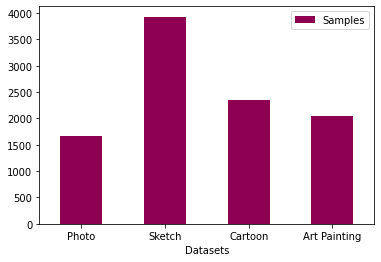

In [0]:
samples = [len(photo_folder), len(sketch_folder), len(cartoon_folder), len(art_painting_folder)]
dataset_list = ['Photo', 'Sketch', 'Cartoon', 'Art Painting']
df = pd.DataFrame(list(zip(dataset_list, samples)), columns =['Datasets', 'Samples']) 
df.plot.bar(x='Datasets', y='Samples', rot=0, cmap= 'PiYG')

# 2 - Net's architecture


In [0]:
class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None

__all__ = ['NetkWithReverseGrad', 'netkWithReverseGrad']


class NetkWithReverseGrad(nn.Module):
    def __init__(self, num_classes=1000):
        super(NetkWithReverseGrad, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.class_classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        

        self.domain_classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        

    def forward(self, x, alpha=None):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        if alpha is not None:
            reverse_feature = ReverseLayerF.apply(x, alpha)
            discriminator_output = self.domain_classifier(reverse_feature).cuda()
            return discriminator_output
        else:
            class_outputs = self.class_classifier(x).cuda()
            return class_outputs

  
def netkWithReverseGrad(pretrained=False, progress=True, **kwargs):
  model = NetkWithReverseGrad(**kwargs)
  if pretrained:
    state_dict = load_state_dict_from_url('https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth', progress=True)
    model.load_state_dict(state_dict, strict=False)
  return model

In [0]:
NUM_CLASSES = 7
net = netkWithReverseGrad(pretrained=True)
net.class_classifier[6] = nn.Linear(4096, NUM_CLASSES)
net.domain_classifier[6] = nn.Linear(4096, NUM_DOMAINS)
net

In [0]:
def test_net(best_net, test_dataloader, test_size, comment=None):

  net = best_net.to(DEVICE) 
  net.train(False) 

  running_corrects = 0
  for images, labels in tqdm(test_dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    outputs = net(images)
    _, preds = torch.max(outputs.data, 1)
    running_corrects += torch.sum(preds == labels.data).data.item()


  accuracy = running_corrects / float(test_size)
  print('Test Accuracy: {}'.format(accuracy))
  return accuracy

# 3A - Training and testing without domain adaptation

In [0]:
def train_net(net, comment, NUM_EPOCHS, BATCH_SIZE, max_batches, optimizer, criterion, scheduler, train_dataloader, test_dataloader, test_size):
  net = net.to(DEVICE) 
  cudnn.benchmark 

  current_step = 0
  best_accuracy = 0
  running_corrects = 0
  total_loss_array = np.zeros(NUM_EPOCHS)
  accuracy_array = np.zeros(NUM_EPOCHS)

  for epoch in range(NUM_EPOCHS):
    for param_group in optimizer.param_groups:
      lr = param_group['lr']
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, lr))
    total_loss = 0
    train_iter = iter(train_dataloader)
   
    
    for phase in ['train', 'test']:
      if phase == 'train':
        try:
          X_s, y_s = next(train_iter)
        except:
          # loader A needs to reset
          train_iter = iter(train_dataloader)
          X_s, y_s = next(train_iter)
        optimizer.zero_grad()
        net.train()
        X_s = X_s.to(DEVICE)
        y_s = y_s.to(DEVICE)
        
        outputs = net(X_s)
        loss = criterion(outputs, y_s)
        total_loss += loss.item()
        loss.backward()  
        optimizer.step() 
        current_step += 1
        

      else:
        #validation or test on target
        net.train(False)
        running_corrects = 0
        for X_t, y_t in test_dataloader:
          X_t = X_t.to(DEVICE)
          y_t = y_t.to(DEVICE)

          outputs = net(X_t)
          _, preds = torch.max(outputs.data, 1)
          running_corrects += torch.sum(preds == y_t.data).data.item()
    print('Total Loss {}'.format(total_loss))
    accuracy = running_corrects / float(test_size)
    total_loss_array[epoch] = total_loss
    accuracy_array[epoch] = accuracy
    print('Test Accuracy: {}'.format(accuracy))
    scheduler.step()
  return total_loss_array, accuracy_array

In [0]:
BATCH_SIZE = 200
photo_dataloader = DataLoader(photo_folder, batch_size=BATCH_SIZE,shuffle=True, num_workers=0, drop_last=True)
art_painting_dataloader = DataLoader(art_painting_folder, batch_size=BATCH_SIZE,shuffle=True, num_workers=0, drop_last=True)

LR = 8e-3           
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-5  
NUM_EPOCHS = 20     
STEP_SIZE = 10       
GAMMA = 0.5       

train_dataloader = photo_dataloader
test_dataloader = art_painting_dataloader
test_size = len(art_painting_folder)
max_batches = len(train_dataloader)
print("N. batches {}".format(max_batches))

net = netkWithReverseGrad(pretrained=True)
net.class_classifier[6] = nn.Linear(4096, NUM_CLASSES)
net.domain_classifier[6] = nn.Linear(4096, NUM_DOMAINS)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

tl_3a, aa_3a = train_net(net, "", NUM_EPOCHS, BATCH_SIZE, max_batches, optimizer, criterion, scheduler, train_dataloader, test_dataloader, test_size)

# 3B - Training and testing with domain adaptation

In [0]:
def train_net_DANN(net, comment, alpha, NUM_EPOCHS, BATCH_SIZE, max_batches, optimizer, loss_class, loss_domain, scheduler, train_dataloader, test_dataloader):
  net = net.to(DEVICE) 
  cudnn.benchmark 

  current_step = 0
  best_accuracy = 0
  total_loss_array = np.zeros(NUM_EPOCHS)
  accuracy_array = np.zeros(NUM_EPOCHS)

  for epoch in range(NUM_EPOCHS):
    total_loss = 0
    for param_group in optimizer.param_groups:
      lr = param_group['lr']
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, lr))
    train_iter = iter(train_dataloader)
    test_iter = iter(test_dataloader)

    #SOURCE GY
    # Train on source domain (labels)
    optimizer.zero_grad()
    
    net.train()
    try:
      X_s, y_s = next(train_iter)
    except:
      # loader A needs to reset
      train_iter = iter(train_dataloader)
      X_s, y_s = next(train_iter)
    X_s = X_s.to(DEVICE)
    y_s = y_s.to(DEVICE)
    outputs_s_labels = net(X_s)
    outputs_s_labels = outputs_s_labels.to(DEVICE)
    loss_s_label = loss_class(outputs_s_labels, y_s)

    #SOURCE GD
    # Train on source domain (domains)
    outputs_s_domain = net(X_s, alpha=alpha)
    outputs_s_domain = outputs_s_domain.to(DEVICE)
    y_s_domain = torch.zeros(BATCH_SIZE, dtype=torch.long) # generate source domain labels
    y_s_domain = y_s_domain.to(DEVICE)
    loss_s_domain = loss_domain(outputs_s_domain, y_s_domain) 
    
    #TARGET GD
    # Test on target domain (domains)
    X_t, _ = next(test_iter)
    X_t = X_t.to(DEVICE)
    y_t_domain = torch.ones(BATCH_SIZE, dtype=torch.long) # generate target domain labels
    y_t_domain = y_t_domain.to(DEVICE)
    domain_pred = net(X_t, alpha=alpha)
    domain_pred = domain_pred.to(DEVICE)
    loss_t_domain = loss_domain(domain_pred, y_t_domain)
    sum_loss = loss_t_domain + loss_s_domain + loss_s_label
    sum_loss.backward()  
    total_loss += sum_loss.item()
    optimizer.step() 
    current_step += 1
    accuracy = test_net(net, test_dataloader, test_size)
    total_loss_array[epoch] = total_loss
    accuracy_array[epoch] = accuracy
    print('Total Loss {}'.format(total_loss))
    if scheduler != "None":
      scheduler.step() 
  return total_loss_array, accuracy_array

In [0]:
BATCH_SIZE = 200
photo_dataloader = DataLoader(photo_folder, batch_size=BATCH_SIZE,shuffle=True, num_workers=0, drop_last=True)
art_painting_dataloader = DataLoader(art_painting_folder, batch_size=BATCH_SIZE,shuffle=True, num_workers=0, drop_last=True)

LR = 1e-3          
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-5  
NUM_EPOCHS = 30         
GAMMA = 0.25
STEP_SIZE = 8    
alpha = 0.08

train_dataloader = photo_dataloader
test_dataloader = art_painting_dataloader
test_size = len(art_painting_folder)
max_batches = len(train_dataloader)
print("N. batches {}".format(max_batches))

net = netkWithReverseGrad(pretrained=True)
net.class_classifier[6] = nn.Linear(4096, NUM_CLASSES)
net.domain_classifier[6] = nn.Linear(4096, NUM_DOMAINS)

loss_class = nn.CrossEntropyLoss()
loss_domain = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

tl_3b, aa_3b = train_net_DANN(net, "", alpha, NUM_EPOCHS, BATCH_SIZE, max_batches, optimizer, loss_class, loss_domain, scheduler, train_dataloader, test_dataloader)

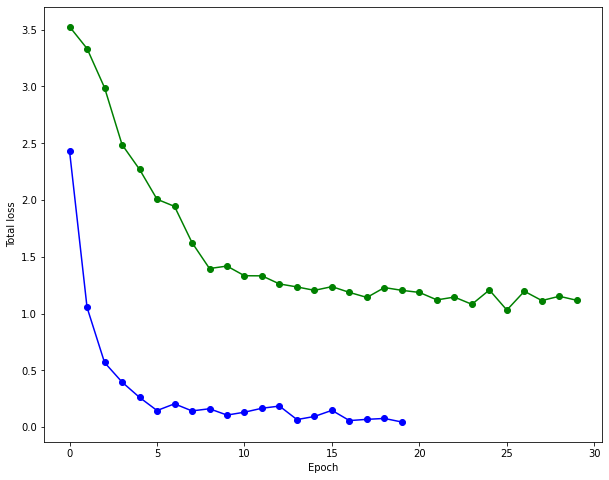

In [0]:
#PLOT TOTAL LOSS
plt.figure(figsize=(10, 8))
plt.plot(np.arange(20), tl_3a, '-ob')
plt.plot(np.arange(30), tl_3b, '-og')
plt.xlabel('Epoch')
plt.ylabel('Total loss')
plt.show()

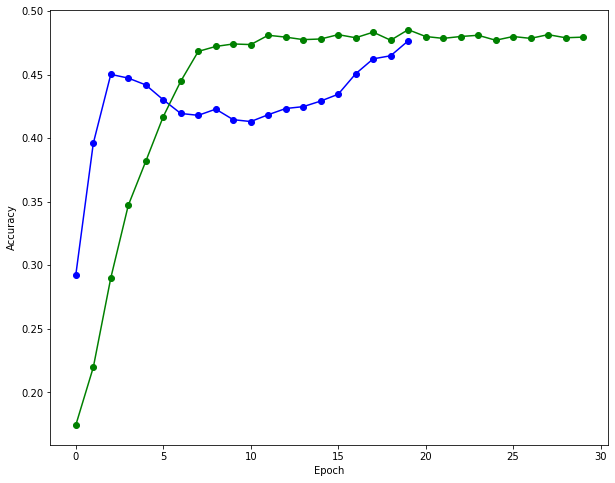

In [0]:
#PLOT ACCURACY
plt.figure(figsize=(10, 8))
plt.plot(np.arange(20), aa_3a, '-ob')
#plt.plot(20, accuracy_test_3_2_1, '*b')
plt.plot(np.arange(30), aa_3b, '-og')
#plt.plot(20, accuracy_test_3_2_2, '*g')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# 4A, 4B - Photo to Cartoon and Photo to Sketch, without Domain Adaptation, implement 3A with the best hyperparameters found in 4A

In [0]:
def train_val_net(net, comment, NUM_EPOCHS, BATCH_SIZE, max_batches, optimizer, criterion, scheduler, photo_dataloader, sketch_dataloader, cartoon_dataloader,size_sketch, size_cartoon):
  net = net.to(DEVICE) 
  cudnn.benchmark 

  current_step = 0
  best_accuracy = 0
  running_corrects = 0
  total_loss_array = np.zeros(NUM_EPOCHS)
  accuracy_array = np.zeros(NUM_EPOCHS)
  accuracy1_array = np.zeros(NUM_EPOCHS)
  accuracy2_array = np.zeros(NUM_EPOCHS)

  for epoch in range(NUM_EPOCHS):
    for param_group in optimizer.param_groups:
      lr = param_group['lr']
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, lr))
    running_loss = 0
    train_iter = iter(photo_dataloader)
   
    for phase in ['train', 'test']:
      if phase == 'train':
        try:
          X_s, y_s = next(train_iter)
        except:
          # loader A needs to reset
          train_iter = iter(photo_dataloader)
          X_s, y_s = next(train_iter)
        optimizer.zero_grad()
        net.train()
        X_s = X_s.to(DEVICE)
        y_s = y_s.to(DEVICE)
        
        outputs = net(X_s)
        loss = criterion(outputs, y_s)
        running_loss += outputs.shape[0] * loss.item()
        loss.backward()  
        optimizer.step() 
        current_step += 1
        

      else:
        #validation or test on target
        net.train(False)
        running_corrects_s = 0
        running_corrects_c = 0
        for X_v1, y_v1 in sketch_dataloader:
          X_v1 = X_v1.to(DEVICE)
          y_v1 = y_v1.to(DEVICE)

          outputs = net(X_v1)
          _, preds = torch.max(outputs.data, 1)
          running_corrects_s += torch.sum(preds == y_v1.data).data.item()
        for X_v2, y_v2 in cartoon_dataloader:
          X_v2 = X_v2.to(DEVICE)
          y_v2 = y_v2.to(DEVICE)

          outputs = net(X_v2)
          _, preds = torch.max(outputs.data, 1)
          running_corrects_c += torch.sum(preds == y_v2.data).data.item()


    epoch_loss = running_loss / len(photo_dataloader)
    print('Epoch Loss {}'.format(epoch_loss))
    accuracy_s = running_corrects_s / float(size_sketch)
    accuracy_c = running_corrects_c / float(size_cartoon)
    mean_acc = (accuracy_s + accuracy_c) / 2
    if mean_acc > best_accuracy:
      best_accuracy = mean_acc
      best_net = type(net)()
      best_net.class_classifier[6] = nn.Linear(4096, NUM_CLASSES)
      best_net.domain_classifier[6] = nn.Linear(4096, NUM_DOMAINS)
      best_net.load_state_dict(net.state_dict()) 

    total_loss_array[epoch] = epoch_loss
    accuracy_array[epoch] = mean_acc
    accuracy1_array[epoch] = accuracy_s
    accuracy2_array[epoch] = accuracy_c
    print('Validation Accuracy sketch: {}, Validation Accuracy cartoon {}, Mean {} '.format(accuracy_s, accuracy_c, mean_acc))
    scheduler.step()
  return best_net, total_loss_array, accuracy_array, accuracy1_array, accuracy2_array

In [0]:
BATCH_SIZE = 200
photo_dataloader = DataLoader(photo_folder, batch_size=BATCH_SIZE,shuffle=True, num_workers=0, drop_last=True)
sketch_dataloader = DataLoader(sketch_folder, batch_size=BATCH_SIZE,shuffle=True, num_workers=0)
cartoon_dataloader = DataLoader(cartoon_folder, batch_size=BATCH_SIZE,shuffle=True, num_workers=0)
art_painting_dataloader = DataLoader(art_painting_folder, batch_size=BATCH_SIZE,shuffle=True, num_workers=0, drop_last=True)
size_sketch = len(sketch_folder)
size_cartoon = len(cartoon_folder)
test_size = len(art_painting_folder)
print("Size sketch {}".format(size_sketch))
print("Size cartoon {}".format(size_cartoon))

max_batches = max(len(photo_dataloader), len(sketch_dataloader))
max_batches = max(max_batches, len(cartoon_dataloader))
print("N. batches {}".format(max_batches))

Size sketch 3929
Size cartoon 2344
N. batches 20


In [0]:
LR = 8e-3           
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-5  
NUM_EPOCHS = 25     
STEP_SIZE = 20       
GAMMA = 0.5    

net = netkWithReverseGrad(pretrained=True)
net.class_classifier[6] = nn.Linear(4096, NUM_CLASSES)
net.domain_classifier[6] = nn.Linear(4096, NUM_DOMAINS)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

best_net, total_loss_array, mean_accuracy_array, accuracy1_array, accuracy2_array  = train_val_net(net, "", NUM_EPOCHS, BATCH_SIZE, max_batches, optimizer, criterion, scheduler, photo_dataloader, sketch_dataloader, cartoon_dataloader, size_sketch, size_cartoon)
accuracy = test_net(best_net, art_painting_dataloader, test_size)
print("Total loss array {}".format(total_loss_array))
print("Mean accuracy array {}".format(mean_accuracy_array))
print("Validation Accuracy on sketch {}".format(accuracy1_array))
print("Validation Accuracy on cartoon {}".format(accuracy2_array))
print("TAccuracy test {}".format(accuracy))

In [0]:
LR = 2e-3           
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-5  
NUM_EPOCHS = 40     
STEP_SIZE = 10       
GAMMA = 0.5    

net = netkWithReverseGrad(pretrained=True)
net.class_classifier[6] = nn.Linear(4096, NUM_CLASSES)
net.domain_classifier[6] = nn.Linear(4096, NUM_DOMAINS)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

best_net, total_loss_array_1, mean_accuracy_array_1, accuracy1_array_1, accuracy2_array_1  = train_val_net(net, "", NUM_EPOCHS, BATCH_SIZE, max_batches, optimizer, criterion, scheduler, photo_dataloader, sketch_dataloader, cartoon_dataloader, size_sketch, size_cartoon)
accuracy_1 = test_net(best_net, art_painting_dataloader, test_size)
print("Total loss array {}".format(total_loss_array_1))
print("Mean accuracy array {}".format(mean_accuracy_array_1))
print("Validation Accuracy on sketch {}".format(accuracy1_array_1))
print("Validation Accuracy on cartoon {}".format(accuracy2_array_1))
print("TAccuracy test {}".format(accuracy_1))

In [0]:
LR = 8e-3           
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-5  
NUM_EPOCHS = 25  
STEP_SIZE = 10       
GAMMA = 0.5       

net = netkWithReverseGrad(pretrained=True)
net.class_classifier[6] = nn.Linear(4096, NUM_CLASSES)
net.domain_classifier[6] = nn.Linear(4096, NUM_DOMAINS)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

best_net, total_loss_array_2, mean_accuracy_array_2, accuracy1_array_2, accuracy2_array_2  = train_val_net(net, "", NUM_EPOCHS, BATCH_SIZE, max_batches, optimizer, criterion, scheduler, photo_dataloader, sketch_dataloader, cartoon_dataloader, size_sketch, size_cartoon)
accuracy_2 = test_net(best_net, art_painting_dataloader, test_size)
print("Total loss array {}".format(total_loss_array_2))
print("Mean accuracy array {}".format(mean_accuracy_array_2))
print("Validation Accuracy on sketch {}".format(accuracy1_array_2))
print("Validation Accuracy on cartoon {}".format(accuracy2_array_2))
print("TAccuracy test {}".format(accuracy_2))

In [0]:
LR = 4e-3           
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-5  
NUM_EPOCHS = 25  
STEP_SIZE = 20       
GAMMA = 0.5       

net = netkWithReverseGrad(pretrained=True)
net.class_classifier[6] = nn.Linear(4096, NUM_CLASSES)
net.domain_classifier[6] = nn.Linear(4096, NUM_DOMAINS)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

best_net, total_loss_array_3, mean_accuracy_array_3, accuracy1_array_3, accuracy2_array_3 = train_val_net(net, "", NUM_EPOCHS, BATCH_SIZE, max_batches, optimizer, criterion, scheduler, photo_dataloader, sketch_dataloader, cartoon_dataloader, size_sketch, size_cartoon)
accuracy_3 = test_net(best_net, art_painting_dataloader, test_size)
print("Total loss array {}".format(total_loss_array_3))
print("Mean accuracy array {}".format(mean_accuracy_array_3))
print("Validation Accuracy on sketch {}".format(accuracy1_array_3))
print("Validation Accuracy on cartoon {}".format(accuracy2_array_3))
print("TAccuracy test {}".format(accuracy_3))

In [0]:
LR = 4e-3           
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-5  
NUM_EPOCHS = 25  
STEP_SIZE = 10       
GAMMA = 0.1       

net = netkWithReverseGrad(pretrained=True)
net.class_classifier[6] = nn.Linear(4096, NUM_CLASSES)
net.domain_classifier[6] = nn.Linear(4096, NUM_DOMAINS)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

best_net, total_loss_array_4, mean_accuracy_array_4, accuracy1_array_4, accuracy2_array_4 = train_val_net(net, "", NUM_EPOCHS, BATCH_SIZE, max_batches, optimizer, criterion, scheduler, photo_dataloader, sketch_dataloader, cartoon_dataloader, size_sketch, size_cartoon)
accuracy_4 = test_net(best_net, art_painting_dataloader, test_size)
print("Total loss array {}".format(total_loss_array_4))
print("Mean accuracy array {}".format(mean_accuracy_array_4))
print("Validation Accuracy on sketch {}".format(accuracy1_array_4))
print("Validation Accuracy on cartoon {}".format(accuracy2_array_4))
print("TAccuracy test {}".format(accuracy_4))

In [0]:
LR = 8e-2           
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-5  
NUM_EPOCHS = 25  
STEP_SIZE = 20       
GAMMA = 0.5       

net = netkWithReverseGrad(pretrained=True)
net.class_classifier[6] = nn.Linear(4096, NUM_CLASSES)
net.domain_classifier[6] = nn.Linear(4096, NUM_DOMAINS)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

best_net, total_loss_array_5, mean_accuracy_array_5, accuracy1_array_5, accuracy2_array_5 = train_val_net(net, "", NUM_EPOCHS, BATCH_SIZE, max_batches, optimizer, criterion, scheduler, photo_dataloader, sketch_dataloader, cartoon_dataloader, size_sketch, size_cartoon)
accuracy_5 = test_net(best_net, art_painting_dataloader, test_size)
print("Total loss array {}".format(total_loss_array_5))
print("Mean accuracy array {}".format(mean_accuracy_array_5))
print("Validation Accuracy on sketch {}".format(accuracy1_array_5))
print("Validation Accuracy on cartoon {}".format(accuracy2_array_5))
print("TAccuracy test {}".format(accuracy_5))

In [0]:
#PLOT TOTAL LOSS
plt.figure(figsize=(10, 8))
plt.plot(np.arange(25), total_loss_array, '-ob')
plt.plot(np.arange(25), total_loss_array_1, '-og')
plt.plot(np.arange(25), total_loss_array_2, '-or')
plt.plot(np.arange(25), total_loss_array_3, '-om')
plt.plot(np.arange(25), total_loss_array_4, '-oy')
plt.xlabel('Epoch')
plt.ylabel('Total loss')
plt.show()

In [0]:
#PLOT MEAN ACC ARRAY
plt.figure(figsize=(10, 8))
plt.plot(np.arange(25), mean_accuracy_array, '-ob')
plt.plot(np.arange(25), mean_accuracy_array_1, '-og')
plt.plot(np.arange(25), mean_accuracy_array_2, '-or')
plt.plot(np.arange(25), mean_accuracy_array_3, '-om')
plt.plot(np.arange(25), mean_accuracy_array_4, '-oy')
plt.plot(25, accuracy, '-ob')
plt.plot(25, accuracy_1, '-og')
plt.plot(25, accuracy_2, '-or')
plt.plot(25, accuracy_3, '-om')
plt.plot(25, accuracy_4, '-oy')
plt.xlabel('Epoch')
plt.ylabel('Mean of the validation accuracies')
plt.show()

In [0]:
#PLOT SKETCH ACC ARRAY
plt.figure(figsize=(10, 8))
plt.plot(np.arange(25), accuracy1_array, '-ob')
plt.plot(np.arange(25), accuracy1_array_1, '-og')
plt.plot(np.arange(25), accuracy1_array_2, '-or')
plt.plot(np.arange(25), accuracy1_array_3, '-om')
plt.plot(np.arange(25), accuracy1_array_4, '-oy')
plt.xlabel('Epoch')
plt.ylabel('Sketch validation accuracy')
plt.show()

In [0]:
#PLOT CARTOON ACC ARRAY
plt.figure(figsize=(10, 8))
plt.plot(np.arange(25), accuracy2_array, '-ob')
plt.plot(np.arange(25), accuracy2_array_1, '-og')
plt.plot(np.arange(25), accuracy2_array_2, '-or')
plt.plot(np.arange(25), accuracy2_array_3, '-om')
plt.plot(np.arange(25), accuracy2_array_4, '-oy')
plt.xlabel('Epoch')
plt.ylabel('Cartoon validation accuracy')
plt.show()

# 4C, 4D - Photo to Cartoon and Photo to Sketch, with Domain Adaptation, Implement 3B with the best hyperparameters found in 4C

In [0]:
def train_val_net_DANN(net, comment, alpha, NUM_EPOCHS, BATCH_SIZE, max_batches, optimizer, loss_class, loss_domain, scheduler, train_dataloader, val_dataloader,size_val):
  net = net.to(DEVICE) 
  cudnn.benchmark 
  current_step = 0
  best_accuracy = 0
  total_loss_array = np.zeros(NUM_EPOCHS)
  accuracy_array = np.zeros(NUM_EPOCHS)

  for epoch in range(NUM_EPOCHS):
    running_loss = 0
    for param_group in optimizer.param_groups:
      lr = param_group['lr']
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, lr))
    train_iter = iter(train_dataloader)
    val_iter = iter(val_dataloader)
    for phase in ['train', 'test']:

      if phase == 'train':
        #SOURCE GY
        # Train on source domain (labels)
        optimizer.zero_grad()
        
        net.train()
        try:
          X_s, y_s = next(train_iter)
        except:
          # loader A needs to reset
          train_iter = iter(train_dataloader)
          X_s, y_s = next(train_iter)
        X_s = X_s.to(DEVICE)
        y_s = y_s.to(DEVICE)
        outputs_s_labels = net(X_s)
        outputs_s_labels = outputs_s_labels.to(DEVICE)
        loss_s_label = loss_class(outputs_s_labels, y_s)
        #running_loss += outputs.shape[0] * loss.item()

        #SOURCE GD
        # Train on source domain (domains)
        outputs_s_domain = net(X_s, alpha=alpha)
        outputs_s_domain = outputs_s_domain.to(DEVICE)
        y_s_domain = torch.zeros(BATCH_SIZE, dtype=torch.long) # generate source domain labels
        y_s_domain = y_s_domain.to(DEVICE)
        loss_s_domain = loss_domain(outputs_s_domain, y_s_domain) 
        
        #TARGET GD
        # Test on target domain (domains)
        X_t, _ = next(val_iter)
        X_t = X_t.to(DEVICE)
        y_t_domain = torch.ones(BATCH_SIZE, dtype=torch.long) # generate target domain labels
        y_t_domain = y_t_domain.to(DEVICE)
        domain_pred = net(X_t, alpha=alpha)
        domain_pred = domain_pred.to(DEVICE)
        loss_t_domain = loss_domain(domain_pred, y_t_domain)
        sum_loss = loss_t_domain + loss_s_domain + loss_s_label
        sum_loss.backward()  
        #epoch_loss = running_loss / len(train_dataloader)
        #total_loss += sum_loss.item()
        optimizer.step() 
        current_step += 1
      
      else:
        net.train(False)
        running_corrects = 0
        for X_v, y_v in sketch_dataloader:
          X_v = X_v.to(DEVICE)
          y_v = y_v.to(DEVICE)

          outputs = net(X_v)
          _, preds = torch.max(outputs.data, 1)
          running_corrects += torch.sum(preds == y_v.data).data.item()

    accuracy = running_corrects/ float(size_val)
    if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_net = type(net)()
      best_net.class_classifier[6] = nn.Linear(4096, NUM_CLASSES)
      best_net.domain_classifier[6] = nn.Linear(4096, NUM_DOMAINS)
      best_net.load_state_dict(net.state_dict()) 

    total_loss_array[epoch] = sum_loss
    accuracy_array[epoch] = accuracy
    print('Total Loss {}, Loss Source label {}, Loss source domain {} Loss Target domain {}'.format(sum_loss, loss_s_label, loss_s_domain, loss_t_domain))
    print('Validation Accuracy: {}'.format(accuracy))
    scheduler.step() 
  
  return total_loss_array, accuracy_array, best_accuracy
    

In [0]:
BATCH_SIZE = 200
photo_dataloader = DataLoader(photo_folder, batch_size=BATCH_SIZE,shuffle=True, num_workers=0, drop_last=True)
sketch_dataloader = DataLoader(sketch_folder, batch_size=BATCH_SIZE,shuffle=True, num_workers=0)
cartoon_dataloader = DataLoader(cartoon_folder, batch_size=BATCH_SIZE,shuffle=True, num_workers=0)
art_painting_dataloader = DataLoader(art_painting_folder, batch_size=BATCH_SIZE,shuffle=True, num_workers=0, drop_last=True)
size_sketch = len(sketch_folder)
size_cartoon = len(cartoon_folder)
test_size = len(art_painting_folder)
print("Size sketch {}".format(size_sketch))
print("Size cartoon {}".format(size_cartoon))

max_batches = max(len(photo_dataloader), len(sketch_dataloader))
max_batches = max(max_batches, len(cartoon_dataloader))
print("N. batches {}".format(max_batches))

Size sketch 3929
Size cartoon 2344
N. batches 20


In [0]:
LR = 5e-3           
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-5  
NUM_EPOCHS = 30     
STEP_SIZE = 10       
GAMMA = 0.25 
alpha = 0.25

net = netkWithReverseGrad(pretrained=True)
net.class_classifier[6] = nn.Linear(4096, NUM_CLASSES)
net.domain_classifier[6] = nn.Linear(4096, NUM_DOMAINS)

loss_class = nn.CrossEntropyLoss()
loss_domain = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
print("----------------CARTOON --------------------")
total_loss_array_c_1, accuracy_array_c_1, best_accuracy_c_1 = train_val_net_DANN(net, "", alpha, NUM_EPOCHS, BATCH_SIZE, max_batches, optimizer, loss_class, loss_domain, scheduler, photo_dataloader, cartoon_dataloader, size_cartoon)

LR = 5e-3    
MOMENTUM = 0.9     

net = netkWithReverseGrad(pretrained=True)
net.class_classifier[6] = nn.Linear(4096, NUM_CLASSES)
net.domain_classifier[6] = nn.Linear(4096, NUM_DOMAINS)

loss_class = nn.CrossEntropyLoss()
loss_domain = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
print("----------------SKETCH --------------------")
total_loss_array_s_1, accuracy_array_s_1, best_accuracy_s_1 = train_val_net_DANN(net, "", alpha, NUM_EPOCHS, BATCH_SIZE, max_batches, optimizer, loss_class, loss_domain, scheduler, photo_dataloader, sketch_dataloader, size_sketch)
mean_1 = (accuracy_array_c_1 + accuracy_array_s_1) / 2
print("----------------MEAN {} --------------------".format(mean_1))

LR = 5e-3    
MOMENTUM = 0.9    
net = netkWithReverseGrad(pretrained=True)
net.class_classifier[6] = nn.Linear(4096, NUM_CLASSES)
net.domain_classifier[6] = nn.Linear(4096, NUM_DOMAINS)
loss_class = nn.CrossEntropyLoss()
loss_domain = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

train_net_DANN(net, "", alpha, NUM_EPOCHS, BATCH_SIZE, max_batches, optimizer, loss_class, loss_domain, scheduler, photo_dataloader, art_painting_dataloader)
accuracy_1 = test_net(net, art_painting_dataloader, test_size)

In [0]:
LR = 5e-3           
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-5  
NUM_EPOCHS = 20     
STEP_SIZE = 10      
GAMMA = 0.5   
alpha = 0.1

net = netkWithReverseGrad(pretrained=True)
net.class_classifier[6] = nn.Linear(4096, NUM_CLASSES)
net.domain_classifier[6] = nn.Linear(4096, NUM_DOMAINS)

loss_class = nn.CrossEntropyLoss()
loss_domain = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
print("----------------CARTOON --------------------")
total_loss_array_c_2, accuracy_array_c_2, best_accuracy_c_2 = train_val_net_DANN(net, "", alpha, NUM_EPOCHS, BATCH_SIZE, max_batches, optimizer, loss_class, loss_domain, scheduler, photo_dataloader, cartoon_dataloader, size_cartoon)

LR = 5e-3           
NUM_EPOCHS = 20     
STEP_SIZE = 10      
GAMMA = 0.5   
alpha = 0.1 

net = netkWithReverseGrad(pretrained=True)
net.class_classifier[6] = nn.Linear(4096, NUM_CLASSES)
net.domain_classifier[6] = nn.Linear(4096, NUM_DOMAINS)

loss_class = nn.CrossEntropyLoss()
loss_domain = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
print("----------------SKETCH --------------------")
total_loss_array_s_2, accuracy_array_s_2, best_accuracy_s_2 = train_val_net_DANN(net, "", alpha, NUM_EPOCHS, BATCH_SIZE, max_batches, optimizer, loss_class, loss_domain, scheduler, photo_dataloader, sketch_dataloader, size_sketch)
mean_2 = (accuracy_array_c_2 + accuracy_array_s_2) / 2
print("----------------MEAN {} --------------------".format(mean_2))

LR = 5e-3           
NUM_EPOCHS = 20     
STEP_SIZE = 10      
GAMMA = 0.5   
alpha = 0.1 
net = netkWithReverseGrad(pretrained=True)
net.class_classifier[6] = nn.Linear(4096, NUM_CLASSES)
net.domain_classifier[6] = nn.Linear(4096, NUM_DOMAINS)
loss_class = nn.CrossEntropyLoss()
loss_domain = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

train_net_DANN(net, "", alpha, NUM_EPOCHS, BATCH_SIZE, max_batches, optimizer, loss_class, loss_domain, scheduler, photo_dataloader, art_painting_dataloader)
accuracy_2 = test_net(net, art_painting_dataloader, test_size)

In [0]:
LR = 8e-3           
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-5  
NUM_EPOCHS = 25    
STEP_SIZE = 10       
GAMMA = 0.25   
alpha = 0.1 

net = netkWithReverseGrad(pretrained=True)
net.class_classifier[6] = nn.Linear(4096, NUM_CLASSES)
net.domain_classifier[6] = nn.Linear(4096, NUM_DOMAINS)

loss_class = nn.CrossEntropyLoss()
loss_domain = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
print("----------------CARTOON --------------------")
total_loss_array_c_3, accuracy_array_c_3, best_accuracy_c_3 = train_val_net_DANN(net, "", alpha, NUM_EPOCHS, BATCH_SIZE, max_batches, optimizer, loss_class, loss_domain, scheduler, photo_dataloader, cartoon_dataloader, size_cartoon)

LR = 8e-3           
NUM_EPOCHS = 25    
STEP_SIZE = 10       
GAMMA = 0.25   
alpha = 0.1
net = netkWithReverseGrad(pretrained=True)
net.class_classifier[6] = nn.Linear(4096, NUM_CLASSES)
net.domain_classifier[6] = nn.Linear(4096, NUM_DOMAINS)
loss_class = nn.CrossEntropyLoss()
loss_domain = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
print("----------------SKETCH --------------------")
total_loss_array_s_3, accuracy_array_s_3, best_accuracy_s_3 = train_val_net_DANN(net, "", alpha, NUM_EPOCHS, BATCH_SIZE, max_batches, optimizer, loss_class, loss_domain, scheduler, photo_dataloader, sketch_dataloader, size_sketch)
mean_3 = (accuracy_array_c_3 + accuracy_array_s_3) / 2
print("----------------MEAN {} --------------------".format(mean_3))

LR = 8e-3           
NUM_EPOCHS = 25    
STEP_SIZE = 10       
GAMMA = 0.25   
alpha = 0.1
net = netkWithReverseGrad(pretrained=True)
net.class_classifier[6] = nn.Linear(4096, NUM_CLASSES)
net.domain_classifier[6] = nn.Linear(4096, NUM_DOMAINS)
loss_class = nn.CrossEntropyLoss()
loss_domain = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

train_net_DANN(net, "", alpha, NUM_EPOCHS, BATCH_SIZE, max_batches, optimizer, loss_class, loss_domain, scheduler, photo_dataloader, art_painting_dataloader)
accuracy_3 = test_net(net, art_painting_dataloader, test_size)

In [0]:
LR = 1e-4           
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-5  
NUM_EPOCHS = 25    
STEP_SIZE = 10       
GAMMA = 0.25   
alpha = 0.15 

net = netkWithReverseGrad(pretrained=True)
net.class_classifier[6] = nn.Linear(4096, NUM_CLASSES)
net.domain_classifier[6] = nn.Linear(4096, NUM_DOMAINS)

loss_class = nn.CrossEntropyLoss()
loss_domain = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
print("----------------CARTOON --------------------")
total_loss_array_c_4, accuracy_array_c_4, best_accuracy_c_4 = train_val_net_DANN(net, "", alpha, NUM_EPOCHS, BATCH_SIZE, max_batches, optimizer, loss_class, loss_domain, scheduler, photo_dataloader, cartoon_dataloader, size_cartoon)

LR = 1e-4           
NUM_EPOCHS = 25    
STEP_SIZE = 10       
GAMMA = 0.25   
alpha = 0.15 

net = netkWithReverseGrad(pretrained=True)
net.class_classifier[6] = nn.Linear(4096, NUM_CLASSES)
net.domain_classifier[6] = nn.Linear(4096, NUM_DOMAINS)

loss_class = nn.CrossEntropyLoss()
loss_domain = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
print("----------------SKETCH --------------------")
total_loss_array_s_4, accuracy_array_s_4, best_accuracy_s_4 = train_val_net_DANN(net, "", alpha, NUM_EPOCHS, BATCH_SIZE, max_batches, optimizer, loss_class, loss_domain, scheduler, photo_dataloader, sketch_dataloader, size_sketch)
mean_4 = (accuracy_array_c_4 + accuracy_array_s_4) / 2
print("----------------MEAN {} --------------------".format(mean_4))

LR = 1e-4           
NUM_EPOCHS = 25    
STEP_SIZE = 10       
GAMMA = 0.25   
alpha = 0.15 
net = netkWithReverseGrad(pretrained=True)
net.class_classifier[6] = nn.Linear(4096, NUM_CLASSES)
net.domain_classifier[6] = nn.Linear(4096, NUM_DOMAINS)
loss_class = nn.CrossEntropyLoss()
loss_domain = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
train_net_DANN(net, "", alpha, NUM_EPOCHS, BATCH_SIZE, max_batches, optimizer, loss_class, loss_domain, scheduler, photo_dataloader, art_painting_dataloader)
accuracy_4 = test_net(net, art_painting_dataloader, test_size)

In [0]:
LR = 8e-3           
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-5  
NUM_EPOCHS = 25    
STEP_SIZE = 10       
GAMMA = 0.25   
alpha = 0.1 

net = netkWithReverseGrad(pretrained=True)
net.class_classifier[6] = nn.Linear(4096, NUM_CLASSES)
net.domain_classifier[6] = nn.Linear(4096, NUM_DOMAINS)

loss_class = nn.CrossEntropyLoss()
loss_domain = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
print("----------------CARTOON --------------------")
total_loss_array_c_5, accuracy_array_c_5, best_accuracy_c_5 = train_val_net_DANN(net, "", alpha, NUM_EPOCHS, BATCH_SIZE, max_batches, optimizer, loss_class, loss_domain, scheduler, photo_dataloader, cartoon_dataloader, size_cartoon)

LR = 8e-3           
NUM_EPOCHS = 25    
STEP_SIZE = 10       
GAMMA = 0.25   
alpha = 0.1 

net = netkWithReverseGrad(pretrained=True)
net.class_classifier[6] = nn.Linear(4096, NUM_CLASSES)
net.domain_classifier[6] = nn.Linear(4096, NUM_DOMAINS)

optimizer = optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
print("----------------SKETCH --------------------")
total_loss_array_s_5, accuracy_array_s_5, best_accuracy_s_5 = train_val_net_DANN(net, "", alpha, NUM_EPOCHS, BATCH_SIZE, max_batches, optimizer, loss_class, loss_domain, scheduler, photo_dataloader, sketch_dataloader, size_sketch)
mean_5 = (accuracy_array_c_5 + accuracy_array_s_5) / 2
print("----------------MEAN {} --------------------".format(mean_5))


LR = 8e-3           
NUM_EPOCHS = 25    
STEP_SIZE = 10       
GAMMA = 0.25   
alpha = 0.1 
net = netkWithReverseGrad(pretrained=True)
net.class_classifier[6] = nn.Linear(4096, NUM_CLASSES)
net.domain_classifier[6] = nn.Linear(4096, NUM_DOMAINS)
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
train_net_DANN(net, "", alpha, NUM_EPOCHS, BATCH_SIZE, max_batches, optimizer, loss_class, loss_domain, scheduler, photo_dataloader, art_painting_dataloader)
accuracy_5 = test_net(net, art_painting_dataloader, test_size)

In [0]:
#PLOT TOTAL LOSS
plt.figure(figsize=(10, 8))
plt.plot(np.arange(20), total_loss_array_s_1, '-ob')
plt.plot(np.arange(20), total_loss_array_s_2, '-og')
plt.plot(np.arange(25), total_loss_array_s_3, '-or')
plt.plot(np.arange(25), total_loss_array_s_4, '-om')
plt.plot(np.arange(25), total_loss_array_s_5, '-oy')
plt.xlabel('Epoch')
plt.ylabel('Total loss Sketch')
plt.show()

In [0]:
#PLOT TOTAL LOSS
plt.figure(figsize=(10, 8))
plt.plot(np.arange(20), total_loss_array_c_1, '-ob')
plt.plot(np.arange(20), total_loss_array_c_2, '-og')
plt.plot(np.arange(25), total_loss_array_c_3, '-or')
plt.plot(np.arange(25), total_loss_array_c_4, '-om')
plt.plot(np.arange(25), total_loss_array_c_5, '-oy')
plt.xlabel('Epoch')
plt.ylabel('Total loss Cartoon')
plt.show()

In [0]:
#PLOT MEAN ACC
plt.figure(figsize=(10, 8))
plt.plot(np.arange(20), mean_1, '-ob')
plt.plot(np.arange(20), mean_2, '-og')
plt.plot(np.arange(25), mean_3, '-or')
plt.plot(np.arange(25), mean_4, '-om')
plt.plot(np.arange(25), mean_5, '-oy')
plt.xlabel('Epoch')
plt.ylabel('Mean validation accuracies')
plt.show()

In [0]:
#PLOT SKETCH VAL ACC
plt.figure(figsize=(10, 8))
plt.plot(np.arange(20), accuracy_array_s_1, '-ob')
plt.plot(np.arange(20), accuracy_array_s_2, '-og')
plt.plot(np.arange(25), accuracy_array_s_3, '-or')
plt.plot(np.arange(25), accuracy_array_s_4, '-om')
plt.plot(np.arange(25), accuracy_array_s_5, '-oy')
plt.xlabel('Epoch')
plt.ylabel('Sketch validation accuracy')
plt.show()

In [0]:
#PLOT CARTOON VAL ACC
plt.figure(figsize=(10, 8))
plt.plot(np.arange(20), accuracy_array_c_1, '-ob')
plt.plot(np.arange(20), accuracy_array_c_2, '-og')
plt.plot(np.arange(25), accuracy_array_c_3, '-or')
plt.plot(np.arange(25), accuracy_array_c_4, '-om')
plt.plot(np.arange(25), accuracy_array_c_5, '-oy')
plt.xlabel('Epoch')
plt.ylabel('Cartoon validation accuracy')
plt.show()